## Loading libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

## Dataset from https://uk.investing.com/currencies/gbp-sgd-historical-data

In [2]:
#Loading data from 2015 to June 2020
df = pd.read_csv("GBP_SGD Historical Data.csv")
#Reversing the order of daily prices
df = df.iloc[::-1]

In [3]:
print("Earliest FX rates:\n\n",df.head())
print("\n\nDimensions:\n\n",df.shape)

Latest FX rates:

               Date   Price    Open    High     Low Change %
1433  Jan 01, 2015  2.0590  2.0643  2.0658  2.0566   -0.28%
1432  Jan 02, 2015  2.0405  2.0569  2.0671  2.0379   -0.90%
1431  Jan 05, 2015  2.0362  2.0402  2.0447  2.0244   -0.21%
1430  Jan 06, 2015  2.0201  2.0355  2.0382  2.0170   -0.79%
1429  Jan 07, 2015  2.0224  2.0190  2.0267  2.0148    0.11%


Dimensions:

 (1434, 6)


### Converting Date to Datetime data type

In [4]:
df = df.reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'])
#df = df.loc[df['datetime'] > pd.to_datetime('2017-06-28 00:00:00')]

In [5]:
df.head()

,Date,Price,Open,High,Low,Change %
0,2015-01-01,2.0590,2.0643,2.0658,2.0566,-0.28%
1,2015-01-02,2.0405,2.0569,2.0671,2.0379,-0.90%
2,2015-01-05,2.0362,2.0402,2.0447,2.0244,-0.21%
3,2015-01-06,2.0201,2.0355,2.0382,2.0170,-0.79%
4,2015-01-07,2.0224,2.0190,2.0267,2.0148,0.11%


### Taking only "Open" FX rate for each day

In [6]:
dataset = df['Open'].to_numpy()
dataset = dataset.astype('float32')
dataset = dataset.reshape(-1, 1)

In [7]:
dataset.shape

(1434, 1)

### Re-scaling prices to range 0-1

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [9]:
dataset

array([[0.71395326],
       [0.7006986 ],
       [0.6707864 ],
       ...,
       [0.11230516],
       [0.09313989],
       [0.08651257]], dtype=float32)

### Splitting into Train and Test sets

In [10]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Training set size: ", len(train))
print("Test set size: ", len(test))

Training set size:  960
Test set size:  474


In [11]:
#Function to convert an array of values into a dataset matrix with n-look back

def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [12]:
look_back = 10
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

In [13]:
print(trainX.shape)
print(trainY.shape)

(949, 10)
(949,)


In [14]:
#Reshaping input to be [samples, time steps, features]

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [15]:
print(trainX.shape)
print(testX.shape)

(949, 1, 10)
(463, 1, 10)


## Building LSTM model

In [ ]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=256, verbose=2)

In [17]:
#Predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [18]:
#Inverting predictions back to currency scale

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [28]:
#Error calculation

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.5f MSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.5f MSE' % (testScore))


Train Score: 0.02796 MSE
Test Score: 0.03142 MSE


In [20]:
#Shifting train predictions for plotting

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
 

In [21]:
#Shifting test predictions for plotting

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict

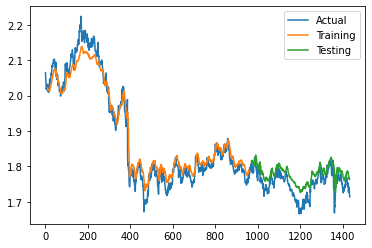

In [22]:
#Plotting results

plt.plot(df['Open'], label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='Testing')
plt.legend(loc='best')
plt.show()

In [24]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 240       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________
None
